In [1]:
# Political Pole Detector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import nltk
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from math import sqrt
import joblib
import string
import re
import sys
import datetime
import html
import os
import timeit
nltk.download('punkt')
nltk.download('wordnet')

# sklearn=0.23.1, pandas=1.0.1
print(sklearn.__version__)
print(pd.__version__)

0.23.1
1.0.1


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# This helps turn .txt files into Excel files .xlsx or CSV files (if you're lucky)
# If files aren't cooperative...run this code then copy and paste the dates into column one
# and articles into column two in Excel, then save as an Excel file.

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            date = line
#            date = date[0:12]
#            with open('csvs/NewsMax.txt', 'a+', encoding='utf-8') as s:
#                s.write(date + "\n")

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            article = line
#            article = article[12:]
#            with open('csvs/NewsMax2.txt', 'a+', encoding='utf-8') as s:
#                s.write(article)

In [3]:
# Let's see what features we have.

# Character length requirement for articles
length_req = 800

left1 = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left1.shape[0]))

for x in range(left1.shape[0]):
    if len(left1['article'][x]) < length_req:
        left1.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left1.shape[0], length_req))

# Only keep the unique article rows and their values
left1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left1.shape[0]))

left1['date'] = left1['date'].str.replace(',', '')

left1.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [4]:
left2 = pd.read_excel("csvs/Salon.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left2.shape[0]))

left2['date'].fillna("", inplace=True)
left2['article'].fillna("", inplace=True)

for x in range(left2.shape[0]):
    if len(left2['article'][x]) < length_req:
        left2.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left2.shape[0], length_req))

# Only keep the unique article rows and their values
left2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left2.shape[0]))

left2['date'] = left2['date'].str.replace(',', '')

left2.head()

We have 2,303 left-wing records
We have 2,278 left-wing records > 800 characters long
1,987 Records are unique


,date,article
0,2020-01-15,"Lev Parnas, the indicted associate of former N..."
1,2020-01-26,President Donald Trump's comments about Thomas...
2,2020-05-31,This article originally appeared at Common Dre...
3,2020-05-31,Trump admin rush migrant children deportations...
4,2020-05-31,"The late Gore Vidal once confessed, with chara..."


In [5]:
left_min = [left1.shape[0], left2.shape[0]]
left_min_entries = min(left_min)

left1 = left1.sample(left_min_entries)
left2 = left2.sample(left_min_entries)

print("Huffpost: {} entries".format(left1.shape[0]))
print("Salon: {} entries".format(left2.shape[0]))

Huffpost: 1987 entries
Salon: 1987 entries


In [6]:
left = pd.concat([left1, left2])
print("We have {:,} left-wing records".format(left.shape[0]))

We have 3,974 left-wing records


In [7]:
# Let's see what features we have.
right1 = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right1.shape[0]))

#count = right.shape[0]

for x in range(right1.shape[0]):
    if len(right1['article'][x]) < length_req:
        right1.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right1.shape[0], length_req))

# Only keep the unique rows and their values
right1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right1.shape[0]))

right1['date'] = right1['date'].str.replace(',', '')

right1.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [8]:
right2 = pd.read_excel("csvs/Redstate.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right2.shape[0]))

#count = right.shape[0]

for x in range(right2.shape[0]):
    if len(right2['article'][x]) < length_req:
        right2.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right2.shape[0], length_req))

# Only keep the unique rows and their values
right2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right2.shape[0]))

right2['date'] = right2['date'].str.replace(',', '')

right2.head()

We have 2,270 right-wing records
We have 2,207 right-wing records > 800 characters long
2,111 Records are unique


,date,article
0,2020-01-15,Even CNN Calls Out Democrats For How They Cele...
1,2020-01-26,The Isolation of Connectivity Image by Thom...
2,2020-05-29,Mayor of Minneapolis Lets Rioters Burn Down Po...
3,2020-05-29,Watch: CNN Crew Arrested by MN State Police Li...
4,2020-05-31,Buffalo Mayor Has Best Response to Rioter Who ...


In [9]:
right_min = [right1.shape[0], right2.shape[0]]
right_min_entries = min(right_min)

right1 = right1.sample(right_min_entries)
right2 = right2.sample(right_min_entries)

print("NewsMax: {} entries".format(right1.shape[0]))
print("Redstate: {} entries".format(right2.shape[0]))

NewsMax: 2111 entries
Redstate: 2111 entries


In [10]:
right = pd.concat([right1, right2])
print("We have {:,} right-wing records".format(right.shape[0]))

We have 4,222 right-wing records


In [11]:
# Check for null values
right.isnull().sum(axis=0)

date       2
article    0
dtype: int64

In [12]:
left.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [13]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [14]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [15]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)

all_data = pd.concat([left, right]) # combine left and right datasets
column_names = all_data.columns.values
all_data.columns = column_names
all_data = all_data.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data['date'] = all_data['date'].str.replace(',', '')
all_data.head()

We have 3,974 left-wing records
We have 4,222 right-wing records
Getting random sample of right-wing records


,date,article,pole
0,2020-04-19,Trump Admits Grudge Kept Romney off Virus Pane...,1
1,2020-03-11,Justices Leave 'Remain in Mexico' Asylum Polic...,1
2,2020-01-19,Dershowitz Stresses Lib Cred Ahead Of Defense ...,1
3,2020-07-25,San Francisco Relaxes Restrictions on Gay Bath...,1
4,2020-03-24,Miami Mayor Francis Suarez to Newsmax TV: My M...,1


In [16]:
print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

# Only keep the unique rows and their values
all_data.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

3,974 / 7,948 Current Records
7,948 Records are unique
3,974 / 7,948 Current Records


In [17]:
# Save the rows used from notspam to a CSV.
# Can give you a good idea of what constitutes a good set of data
# when a run results in high accuracy.
#notspam.to_csv(r'positive.csv')
#spam.to_csv(r'negative.csv')

# We can see there's some strange html characters present.
# Very important to cast the entire column as a string type first, so some of these numeric values come in as strings.
# Otherwise, the row values for these comments where they're present will turn into NaN values.
#all_data['article'] = all_data['article'].astype(str).str.replace(r'&#39;', "\'").astype('string')

# This is a more clean and thorough url decoding function for decoding any character string...
all_data['article'] = all_data['article'].astype(str).apply(lambda x: html.unescape(x))

In [18]:
# Store the original comments in a new column
all_data['unfiltered_articles'] = all_data['article'].values
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-04-19,Trump Admits Grudge Kept Romney off Virus Pane...,1,Trump Admits Grudge Kept Romney off Virus Pane...
1,2020-03-11,Justices Leave 'Remain in Mexico' Asylum Polic...,1,Justices Leave 'Remain in Mexico' Asylum Polic...
2,2020-01-19,Dershowitz Stresses Lib Cred Ahead Of Defense ...,1,Dershowitz Stresses Lib Cred Ahead Of Defense ...
3,2020-07-25,San Francisco Relaxes Restrictions on Gay Bath...,1,San Francisco Relaxes Restrictions on Gay Bath...
4,2020-03-24,Miami Mayor Francis Suarez to Newsmax TV: My M...,1,Miami Mayor Francis Suarez to Newsmax TV: My M...


In [19]:
# Clean the text
# The apostrophes here are very specific.
# The regular ' will not work from keyboard.
# You have to use print(all_data.head()) and copy and paste that apostrophe into the str.replace()
all_data['article'] = all_data['article'].str.lower()
all_data['article'] = all_data['article'].str.replace(r"u.s.", "united states")
all_data['article'] = all_data['article'].str.replace(r"what’s", "what is")
all_data['article'] = all_data['article'].str.replace(r"’s", " ")
all_data['article'] = all_data['article'].str.replace(r"’ve", "have")
all_data['article'] = all_data['article'].str.replace(r"’re", "are")
all_data['article'] = all_data['article'].str.replace(r"’ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can’t", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren’t", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn’t", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn’t", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn’t", "does not")
all_data['article'] = all_data['article'].str.replace(r"don’t", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn’t", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn’t", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven’t", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn’t", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn’t", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn’t", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren’t", "were not")
all_data['article'] = all_data['article'].str.replace(r"won’t", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn’t", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn’t", "must not")
all_data['article'] = all_data['article'].str.replace(r"i’m", "i am")

# As are these apostrophes...
all_data['article'] = all_data['article'].str.replace(r"what's", "what is")
all_data['article'] = all_data['article'].str.replace(r"'s", " ")
all_data['article'] = all_data['article'].str.replace(r"'ve", "have")
all_data['article'] = all_data['article'].str.replace(r"'re", "are")
all_data['article'] = all_data['article'].str.replace(r"'ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can't", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren't", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn't", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn't", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn't", "does not")
all_data['article'] = all_data['article'].str.replace(r"don't", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn't", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn't", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven't", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn't", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn't", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn't", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren't", "were not")
all_data['article'] = all_data['article'].str.replace(r"won't", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn't", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn't", "must not")
all_data['article'] = all_data['article'].str.replace(r"i'm", "i am")
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-04-19,trump admits grudge kept romney off virus pane...,1,Trump Admits Grudge Kept Romney off Virus Pane...
1,2020-03-11,justices leave aremain in mexico' asylum polic...,1,Justices Leave 'Remain in Mexico' Asylum Polic...
2,2020-01-19,dershowitz stresses lib cred ahead of defense ...,1,Dershowitz Stresses Lib Cred Ahead Of Defense ...
3,2020-07-25,san francisco relaxes restrictions on gay bath...,1,San Francisco Relaxes Restrictions on Gay Bath...
4,2020-03-24,miami mayor francis suarez to newsmax tv: my m...,1,Miami Mayor Francis Suarez to Newsmax TV: My M...


In [20]:
# Custom word removal - these appear too frequently and do not help with generalization.
custom = {'donald j trump', 'donald john trump', 'donald j. trump', 'newsmax', 'redstate', 
          "huffpost", 'salon',
          "___", "donald trump", "trump", "pelosi"}

# Did not work
#for word in custom:
#    all_data["article"]= all_data["article"].replace(word, " ") 

# Did not work
#all_data['article'] = all_data['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom)]))

# Did work
#def customWord(text):
#    custom = {'donald j trump', 'donald john trump', 'donald j. trump', "huffpost", "newsmax"}
#    return text.replace("huffpost", " ") 

for word in custom:
    all_data['article'] = all_data['article'].apply(lambda x: x.replace(word, " "))
    
# Check to see the words were replaced
all_data[all_data['article'].str.contains("newsmax")]

,date,article,pole,unfiltered_articles


In [21]:
# Remove years and digits from being used as features
def remove_years(text):
    text = re.sub(r"[0-9]{4}", " ", text)
    text = re.sub(r"[0-9]{3}", " ", text)
    text = re.sub(r"[0-9]{2}", " ", text)
    text = re.sub(r"[0-9]{1}", " ", text)
    text = re.sub(r"[0-9]{4}ish", " ", text)
    text = re.sub(r"[0-9]{3}ish", " ", text)
    text = re.sub(r"[0-9]{2}ish", " ", text)
    text = re.sub(r"[0-9]{1}ish", " ", text)
    text = re.sub(r"2020-[0-9]{2}-[0-9]{2}", " ", text)
    return text

all_data['article'] = all_data['article'].apply(lambda x: remove_years(x))
all_data.head()

# Punctuation removal - CountVectorizer() does this for you
#punctuation = {'.', ':', ';', "\'", '\"', '!', '?', "\’", '(', ')', '-'}

,date,article,pole,unfiltered_articles
0,2020-04-19,admits grudge kept romney off virus panel pr...,1,Trump Admits Grudge Kept Romney off Virus Pane...
1,2020-03-11,justices leave aremain in mexico' asylum polic...,1,Justices Leave 'Remain in Mexico' Asylum Polic...
2,2020-01-19,dershowitz stresses lib cred ahead of defense ...,1,Dershowitz Stresses Lib Cred Ahead Of Defense ...
3,2020-07-25,san francisco relaxes restrictions on gay bath...,1,San Francisco Relaxes Restrictions on Gay Bath...
4,2020-03-24,miami mayor francis suarez to tv: my mild ca...,1,Miami Mayor Francis Suarez to Newsmax TV: My M...


In [22]:
all_data[all_data['article'].str.contains("19")]

,date,article,pole,unfiltered_articles


### One-gram - Stopword removal and no lemmatization

In [23]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.831593
1048840.4764ms
Confusion Matrix:
[[607 158]
 [105 720]]
Accuracy Score : 0.8345911949685535
Report : 
              precision    recall  f1-score   support

        Left       0.85      0.79      0.82       765
       Right       0.82      0.87      0.85       825

    accuracy                           0.83      1590
   macro avg       0.84      0.83      0.83      1590
weighted avg       0.84      0.83      0.83      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.864591
537683.3467999999ms
Confusion Matrix:
[[693  98]
 [114 685]]
Accuracy Score : 0.8666666666666667
Report : 
              precision    recall  f1-score   support

        Left       0.86      0.88      0.87       791
       Right       0.87      0.86      0.87       799

    accuracy                           0.87      1590
   macro avg       0.87      0.87      0.87      1590
weighted avg       0.87      0.87      0.87      1590

LinearSVC Acc

### Voteclassifier - Stopword removal and no lemmatization

In [24]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.882117
1324742.7582ms
Confusion Matrix:
[[710  94]
 [ 88 698]]
Accuracy Score : 0.8855345911949686
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.88      0.89       804
       Right       0.88      0.89      0.88       786

    accuracy                           0.89      1590
   macro avg       0.89      0.89      0.89      1590
weighted avg       0.89      0.89      0.89      1590



In [25]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [26]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [27]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_onegram_sr_nol_nopr.pkl')

['hs_and_nr_onegram_sr_nol_nopr.pkl']

### Bi-gram - Stopword removal and no lemmatization

In [28]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.839686
1439736.4311000002ms
Confusion Matrix:
[[638 129]
 [112 711]]
Accuracy Score : 0.8484276729559749
Report : 
              precision    recall  f1-score   support

        Left       0.85      0.83      0.84       767
       Right       0.85      0.86      0.86       823

    accuracy                           0.85      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.85      0.85      0.85      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.872893
987385.9870000005ms
Confusion Matrix:
[[684 102]
 [ 99 705]]
Accuracy Score : 0.8735849056603774
Report : 
              precision    recall  f1-score   support

        Left       0.87      0.87      0.87       786
       Right       0.87      0.88      0.88       804

    accuracy                           0.87      1590
   macro avg       0.87      0.87      0.87      1590
weighted avg       0.87      0.87      0.87      1590

LinearS

### Voteclassifier - Stopword removal and no lemmatization

In [29]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.888973
1789149.0599999998ms
Confusion Matrix:
[[718 115]
 [ 59 698]]
Accuracy Score : 0.8905660377358491
Report : 
              precision    recall  f1-score   support

        Left       0.92      0.86      0.89       833
       Right       0.86      0.92      0.89       757

    accuracy                           0.89      1590
   macro avg       0.89      0.89      0.89      1590
weighted avg       0.89      0.89      0.89      1590



In [30]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [31]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [32]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_bigram_sr_nol_nopr.pkl')

['hs_and_nr_bigram_sr_nol_nopr.pkl']

### Tri-gram - Stopword removal and no lemmatization

In [33]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.843145
1669389.9847999983ms
Confusion Matrix:
[[670 144]
 [125 651]]
Accuracy Score : 0.8308176100628931
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.82      0.83       814
       Right       0.82      0.84      0.83       776

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.83      0.83      0.83      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.874361
1192589.1116999993ms
Confusion Matrix:
[[681 128]
 [ 73 708]]
Accuracy Score : 0.8735849056603774
Report : 
              precision    recall  f1-score   support

        Left       0.90      0.84      0.87       809
       Right       0.85      0.91      0.88       781

    accuracy                           0.87      1590
   macro avg       0.88      0.87      0.87      1590
weighted avg       0.88      0.87      0.87      1590

Linear

### Voteclassifier - Stopword removal and no lemmatization

In [34]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.889245
2234082.5523999995ms
Confusion Matrix:
[[678 114]
 [ 67 731]]
Accuracy Score : 0.8861635220125786
Report : 
              precision    recall  f1-score   support

        Left       0.91      0.86      0.88       792
       Right       0.87      0.92      0.89       798

    accuracy                           0.89      1590
   macro avg       0.89      0.89      0.89      1590
weighted avg       0.89      0.89      0.89      1590



In [35]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [36]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [37]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_trigram_sr_nol_nopr.pkl')

['hs_and_nr_trigram_sr_nol_nopr.pkl']

In [38]:
# Lemmatization after Word Tokenization
# Higher accuracy and recall consistently resulted from no lemmatization as opposed to lemmatization.
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

lemmatizer = WordNetLemmatizer()
all_data['article'] = all_data.article.apply(lemmatize_text)
all_data.head()

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
6080,2020-06-01,encouraging police brutality and other form vi...,0,Encouraging police brutality and other forms v...
6340,2020-02-21,michael bloomberg is drowning out the small-do...,0,Michael Bloomberg Is Drowning Out The Small-Do...
809,2020-06-09,epidemiologist have raised concern that the pr...,0,Epidemiologists have raised concerns that the ...
5506,2020-06-25,gen. flynn win — for now ? ? the three judge p...,1,Gen. Flynn Wins — For Now?? The three Judge ...
3687,2020-05-22,joe biden sympathizes with pandemic-hit americ...,0,Joe Biden Sympathizes With Pandemic-Hit Americ...


### One-gram - Stopword removal and lemmatization

In [39]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.823208
817648.7008000003ms
Confusion Matrix:
[[650 152]
 [141 647]]
Accuracy Score : 0.8157232704402516
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.81      0.82       802
       Right       0.81      0.82      0.82       788

    accuracy                           0.82      1590
   macro avg       0.82      0.82      0.82      1590
weighted avg       0.82      0.82      0.82      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.858218
465247.07879999914ms
Confusion Matrix:
[[669 140]
 [ 84 697]]
Accuracy Score : 0.8591194968553459
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.83      0.86       809
       Right       0.83      0.89      0.86       781

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590

LinearS

### Voteclassifier - Stopword removal and lemmatization

In [40]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.878889
1788669.1798000028ms
Confusion Matrix:
[[709  83]
 [ 77 721]]
Accuracy Score : 0.89937106918239
Report : 
              precision    recall  f1-score   support

        Left       0.90      0.90      0.90       792
       Right       0.90      0.90      0.90       798

    accuracy                           0.90      1590
   macro avg       0.90      0.90      0.90      1590
weighted avg       0.90      0.90      0.90      1590



In [41]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [42]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [43]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_onegram_sr_l_nopr.pkl')

['hs_and_nr_onegram_sr_l_nopr.pkl']

### Bi-gram - Stopword removal and lemmatization

In [44]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.832662
1859101.200399993ms
Confusion Matrix:
[[646 155]
 [103 686]]
Accuracy Score : 0.8377358490566038
Report : 
              precision    recall  f1-score   support

        Left       0.86      0.81      0.83       801
       Right       0.82      0.87      0.84       789

    accuracy                           0.84      1590
   macro avg       0.84      0.84      0.84      1590
weighted avg       0.84      0.84      0.84      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.864843
1086320.1408000023ms
Confusion Matrix:
[[650 112]
 [ 93 735]]
Accuracy Score : 0.8710691823899371
Report : 
              precision    recall  f1-score   support

        Left       0.87      0.85      0.86       762
       Right       0.87      0.89      0.88       828

    accuracy                           0.87      1590
   macro avg       0.87      0.87      0.87      1590
weighted avg       0.87      0.87      0.87      1590

LinearS

### Voteclassifier - Stopword removal and lemmatization

In [45]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.883040
1597351.0555999964ms
Confusion Matrix:
[[691 104]
 [ 84 711]]
Accuracy Score : 0.8817610062893082
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.87      0.88       795
       Right       0.87      0.89      0.88       795

    accuracy                           0.88      1590
   macro avg       0.88      0.88      0.88      1590
weighted avg       0.88      0.88      0.88      1590



In [46]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [47]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [48]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_bigram_sr_l_nopr.pkl')

['hs_and_nr_bigram_sr_l_nopr.pkl']

### Tri-gram - Stopword removal and lemmatization

In [49]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.830398
2262023.0324000004ms
Confusion Matrix:
[[638 151]
 [120 681]]
Accuracy Score : 0.829559748427673
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.81      0.82       789
       Right       0.82      0.85      0.83       801

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.83      0.83      0.83      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.864340
1808674.5109000038ms
Confusion Matrix:
[[678 132]
 [ 84 696]]
Accuracy Score : 0.8641509433962264
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.84      0.86       810
       Right       0.84      0.89      0.87       780

    accuracy                           0.86      1590
   macro avg       0.87      0.86      0.86      1590
weighted avg       0.87      0.86      0.86      1590

LinearS

### Voteclassifier - Stopword removal and lemmatization

In [50]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.879979
1764555.9784999932ms
Confusion Matrix:
[[663  94]
 [ 86 747]]
Accuracy Score : 0.8867924528301887
Report : 
              precision    recall  f1-score   support

        Left       0.89      0.88      0.88       757
       Right       0.89      0.90      0.89       833

    accuracy                           0.89      1590
   macro avg       0.89      0.89      0.89      1590
weighted avg       0.89      0.89      0.89      1590



In [51]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [52]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [53]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_trigram_sr_l_nopr.pkl')

['hs_and_nr_trigram_sr_l_nopr.pkl']

In [54]:
# This just makes sure the below functions work for seeing
# words that are used as features to detect spam comments.
# It does not retrain the model. That was saved in final_model.
train, test = train_test_split(all_data, test_size=0.2)

# Changing this to n_gram(1,2) may be all you need to do to see some of the top bigrams.
count_vect = CountVectorizer(min_df = 4, max_df = .75, stop_words='english', ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(train.article)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

clf = SGDClassifier().fit(X_train_tfidf, train.pole)

In [55]:
# Shows you the most frequently occurring words seen in text labelled as left or right
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]) 
    print("\t\t%-15s\t\t\t%-15s" % ('Left', 'Right'))
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(count_vect, clf, 40)

		Left           			Right          
	-3.4177	appeared       		2.8275	hill           
	-3.3314	originally appeared		2.5806	democrat       
	-3.2492	article originally		2.1353	left           
	-3.2331	article originally appeared		1.8413	virus          
	-3.1880	originally     		1.8399	piece          
	-2.6615	claimed        		1.8263	dems           
	-2.6124	host           		1.7572	aoc            
	-2.3213	democratic     		1.7354	healthcare     
	-2.2945	covid          		1.7134	alex           
	-2.2131	warned         		1.6921	leftist        
	-2.1535	writer         		1.5964	wuhan          
	-2.0712	asked          		1.5470	medium         
	-2.0320	month          		1.4983	wuhan virus    
	-2.0170	check          		1.4928	axios          
	-1.9884	twitter        		1.4233	report         
	-1.9171	argued         		1.4228	told fox       
	-1.8873	repeatedly     		1.4143	ap photo       
	-1.8784	suggested      		1.3698	discunited     
	-1.8694	appeared raw   		1.3657	riot           
	-1.8694	appea

In [56]:
# Shows you the most frequently occurring words seen in text labelled as right.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['right'], 50)

right: chairman, ig, ch, impact, iwill, morning, china, schumer, counter, rioter, mob, news fox friend, coronavirus outbreak, woke, according hill, mccabe, north, dc, today, ny, told fox news, biden, ferrer, mike bloomberg, hill reported, lockdown, dem, cancel, murphy, wh, fact, riot, discunited, ap photo, told fox, report, axios, wuhan virus, medium, wuhan, leftist, alex, healthcare, aoc, dems, piece, virus, left, democrat, hill


In [57]:
# Shows you the most frequently occurring words seen in text labelled as left.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:n]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['left'], 50)

left: appeared, originally appeared, article originally, article originally appeared, originally, claimed, host, democratic, covid, warned, writer, asked, month, check, twitter, argued, repeatedly, suggested, appeared raw story, originally appeared raw, appeared raw, public, raw story, twitter user, said statement, coronavirus, alternet, washington ap, raw, originally appeared alternet, appeared alternet, new, statement, sponsored, president, reportedly, health care, nationwide, shared, people, article, later, ap, wednesday, expert, care, clinic, staff writer, user, advocate


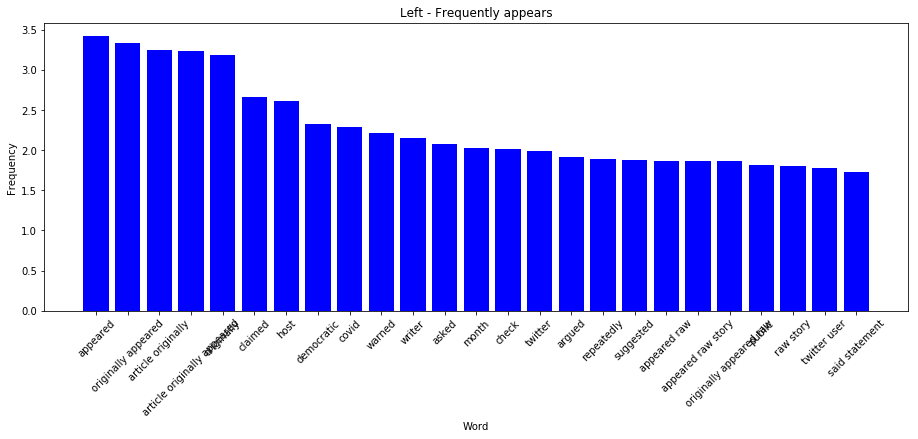

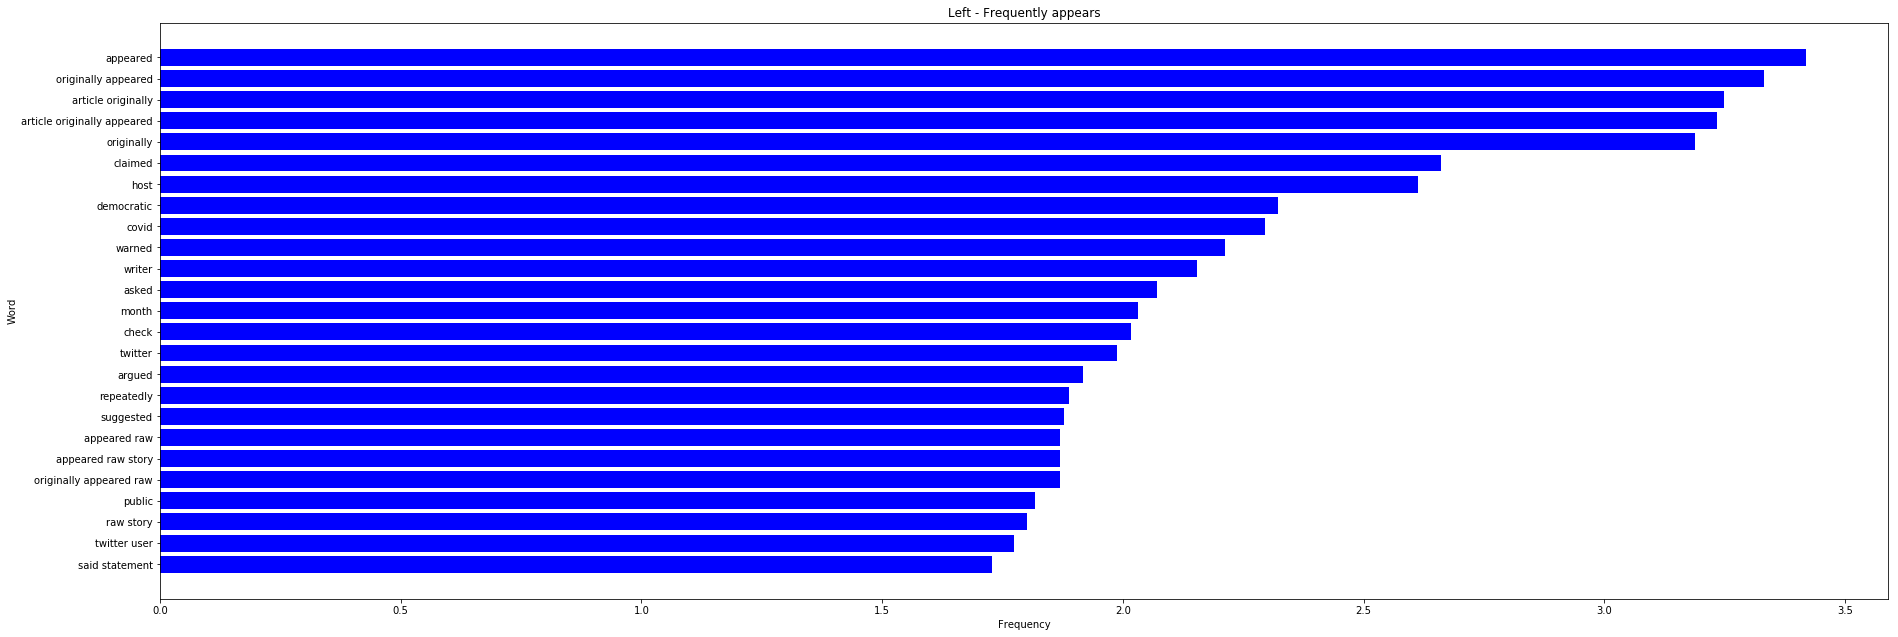

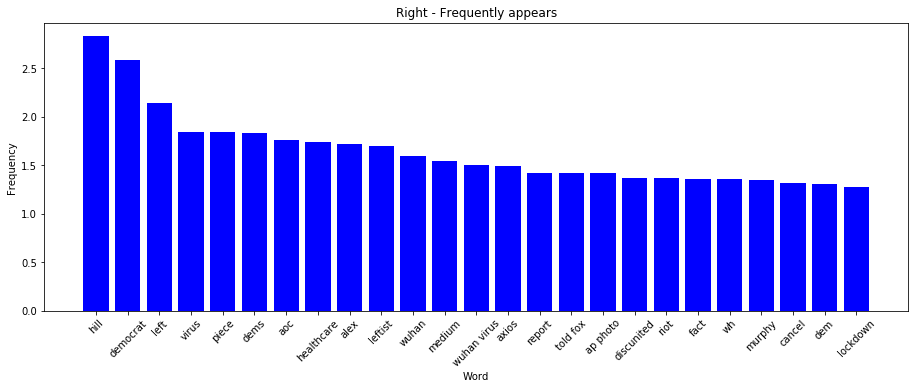

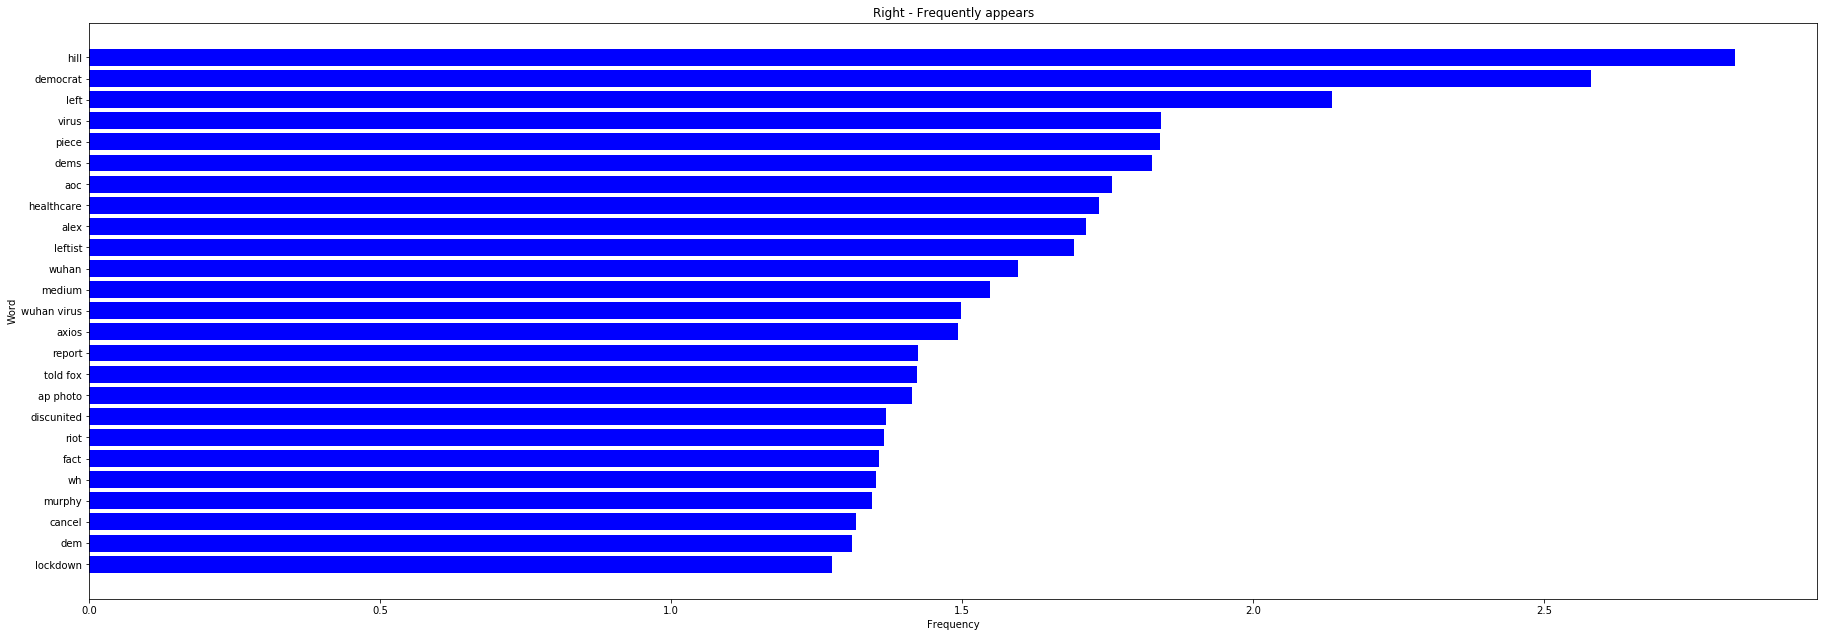

In [58]:
# Plot the most frequently occurring words seen in text labelled as right or left
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def plot_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.bar(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Left - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.barh(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Left - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.bar(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Right - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.barh(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Right - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
plot_most_informative_features(count_vect, clf, 25)

In [59]:
#print(count_vect.get_feature_names())

In [60]:
# Let's save our model
#joblib.dump(text_clf, 'pipeline.pkl')

Confusion Matrix:
[[3844  130]
 [ 102 3872]]
Accuracy Score : 0.9708102667337695
Report : 
              precision    recall  f1-score   support

       Right       0.97      0.97      0.97      3974
        Left       0.97      0.97      0.97      3974

    accuracy                           0.97      7948
   macro avg       0.97      0.97      0.97      7948
weighted avg       0.97      0.97      0.97      7948

             Confusion Matrix


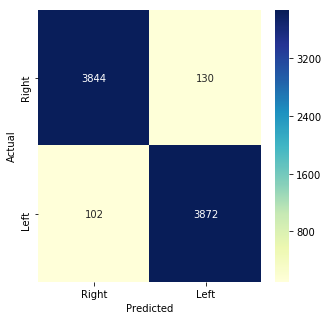

Classification Error of: 0.0291897332662305
95% Confidence Interval of: [0.02548881592285321, 0.03289065060960779]
Left = 0, Right = 1 

Predicted: 0 Actual: 1
Trump Admits Grudge Kept Romney off Virus Panel President Donald Trump admitted Sunday that his exclusion of Sen. Mitt Romney, R-Utah, from a bipartisan group of lawmakers to advise him on reopening the country was because he still holds a grudge against him. A reporter from the Salt Lake Tribune asked Trump during the White House daily press briefing about the coronavirus pandemic and if Romney was the only Republican left off the "Opening Up America Again" congressional group because of a grudge. The two have locked horns in the past, including in February when Romney was the lone Republican to vote guilty on the charge of abuse of office during Trump's Senate impeachment trial. "Yeah, it does. I'm not a fan of Mitt Romney. I had 52 Republican senators," Trump said, alluding to the number of Republicans on the committee. When 

Highest performing classifier: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])


In [61]:
# End Results - Load the model and let's see the end results
text_clf = joblib.load('hs_and_nr_trigram_sr_nol_nopr.pkl')
predicted = text_clf.predict(all_data.unfiltered_articles)
#print(metrics.classification_report(test.pole, predicted, target_names=["NotSpam", "Spam"]))
tn, fp, fn, tp = metrics.confusion_matrix(all_data.pole, predicted).ravel()
results = metrics.confusion_matrix(all_data.pole, predicted)
#print((tn, fp, fn, tp))
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', metrics.accuracy_score(all_data.pole, predicted))
print('Report : ')
print(metrics.classification_report(all_data.pole, predicted, target_names=["Right", "Left"]))


print("             Confusion Matrix")
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(results, annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=["Right","Left"], yticklabels=["Right","Left"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Error
incorrect_predictions = fp + fn
total_predictions = tp + tn + fp + fn
classification_error = incorrect_predictions / total_predictions
print("Classification Error of:",classification_error)

# 95% Confidence Interval (const: 1.96)
# There is a 95% likelihood that the confidence interval [0.xx, 0.xx] 
# covers the true classification error of the model on unseen data.
confidence_interval = []
confidence_interval.append(classification_error - 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
confidence_interval.append(classification_error + 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
print("95% Confidence Interval of:",confidence_interval)

# Let's see some examples of how the model and original dataset is classifying text.
print("Left = 0, Right = 1 \n")
for x in range(5):
    print("Predicted:", predicted[x], end=" ")
    print("Actual:", all_data['pole'][x])
    print(all_data['unfiltered_articles'][x], end="\n\n")

print("Highest performing classifier:", text_clf)

In [62]:
# Write results to results.txt for the entire notebook's run.
acc = metrics.accuracy_score(all_data.pole, predicted)
acc = "Entire dataset accuracy: " + str(acc) + "\n"
f = open('results.txt', 'a+')
f.write(acc)
f.close()

In [70]:
for model, acc in final_model:
    print(acc)

0.8303983228511531
0.8643396226415094
0.8742138364779876
0.8581970649895181
0.6707756813417188
0.7139203354297692
0.8717819706498952
0.879979035639413


In [71]:
for x in range(len(final_model)):
    print(final_model[x])

[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(random_state=0))]), 0.8303983228511531]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0))]), 0.8643396226415094]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0)))]), 0.8742138364779876]
[Pipeline(steps=[('vect',
   

In [73]:
print(text_clf)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])
